## Imports

Install the required libraries using the following command: 


!pip install -r requirements.txt

In [ ]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

import plotly.express as px
import community.community_louvain
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

## Anomaly Detection using Autoencoders

In [16]:
# Load the data
data = pd.read_csv('EID1_extracted.csv')

# Select relevant features
features = ['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']
data = data[features]

data.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
X_train, X_test = train_test_split(data_normalized, test_size=0.2, random_state=42)

# Autoencoder Model
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

# Evaluate the model
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Define your threshold
#threshold = np.percentile(reconstruction_errors, 95)
threshold = np.mean(mse) + 2 * np.std(mse) 

# Predict anomalies
anomaly_indices = np.where(mse > threshold)[0]
anomalies = data.iloc[anomaly_indices].copy()

for col in features:
    anomalies[col] = label_encoders[col].inverse_transform(anomalies[col].astype(int))

anomalies.reset_index(drop=True, inplace=True)

anomalies[['CommandLine', 'Image', 'ParentImage', 'CurrentDirectory']]

Epoch 1/100
19/19 [==============================] - 0s 6ms/step - loss: 1.2532 - val_loss: 1.2887
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 1.2288 - val_loss: 1.2637
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 1.2049 - val_loss: 1.2399
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1803 - val_loss: 1.2124
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1476 - val_loss: 1.1719
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0997 - val_loss: 1.1148
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0328 - val_loss: 1.0350
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9529 - val_loss: 0.9573
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8845 - val_loss: 0.9044
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8404 - val_loss: 0.8712
Epoch 11/

,CommandLine,Image,ParentImage,CurrentDirectory
0,"""C:\Program Files\Npcap\NPFInstall.exe"" -n -d",C:\Program Files\Npcap\NPFInstall.exe,C:\Program Files\Npcap\Uninstall.exe,C:\Program Files\Npcap\
1,"""powershell.exe"" & {Install-Module -Name AADIn...",C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Users\JOHNNY~1.DOU\AppData\Local\Temp\
2,"""C:\Windows\system32\cmd.exe"" /c ""where.exe Sy...",C:\Windows\System32\cmd.exe,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Users\johnny.douche\AppData\Local\Temp\
3,where.exe Sysmon.exe,C:\Windows\System32\where.exe,C:\Windows\System32\cmd.exe,C:\Users\johnny.douche\AppData\Local\Temp\
4,"""C:\Windows\System32\WindowsPowerShell\v1.0\po...",C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Users\JOHNNY~1.DOU\AppData\Local\Temp\
...,...,...,...,...
80,"""C:\Windows\Microsoft.NET\Framework64\v4.0.303...",C:\Windows\Microsoft.NET\Framework64\v4.0.3031...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Users\johnny.douche\AppData\Local\Temp\
81,"""C:\Windows\System32\WindowsPowerShell\v1.0\po...",C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Users\JOHNNY~1.DOU\AppData\Local\Temp\
82,schtasks /query /tn win32times,C:\Windows\System32\schtasks.exe,C:\Windows\System32\cmd.exe,C:\Users\JOHNNY~1.DOU\AppData\Local\Temp\
83,"""powershell.exe"" & {nmap 127.0.0.1}",C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,C:\Users\JOHNNY~1.DOU\AppData\Local\Temp\


## Time for Visulaizations

In [2]:
df = pd.read_csv('sysmonlogs.csv')
df.columns, df.shape

(Index(['IP', 'computer_name', 'Image'], dtype='object'), (14527, 3))

In [ ]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'computer_name','Image')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

In [ ]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df, 'Image','IP')

part = community.community_louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

figure(figsize=(25, 20))
nx.draw_spring(G, node_color=values,with_labels=False)

## [Isolation Forest](https://www.geeksforgeeks.org/what-is-isolation-forest/)

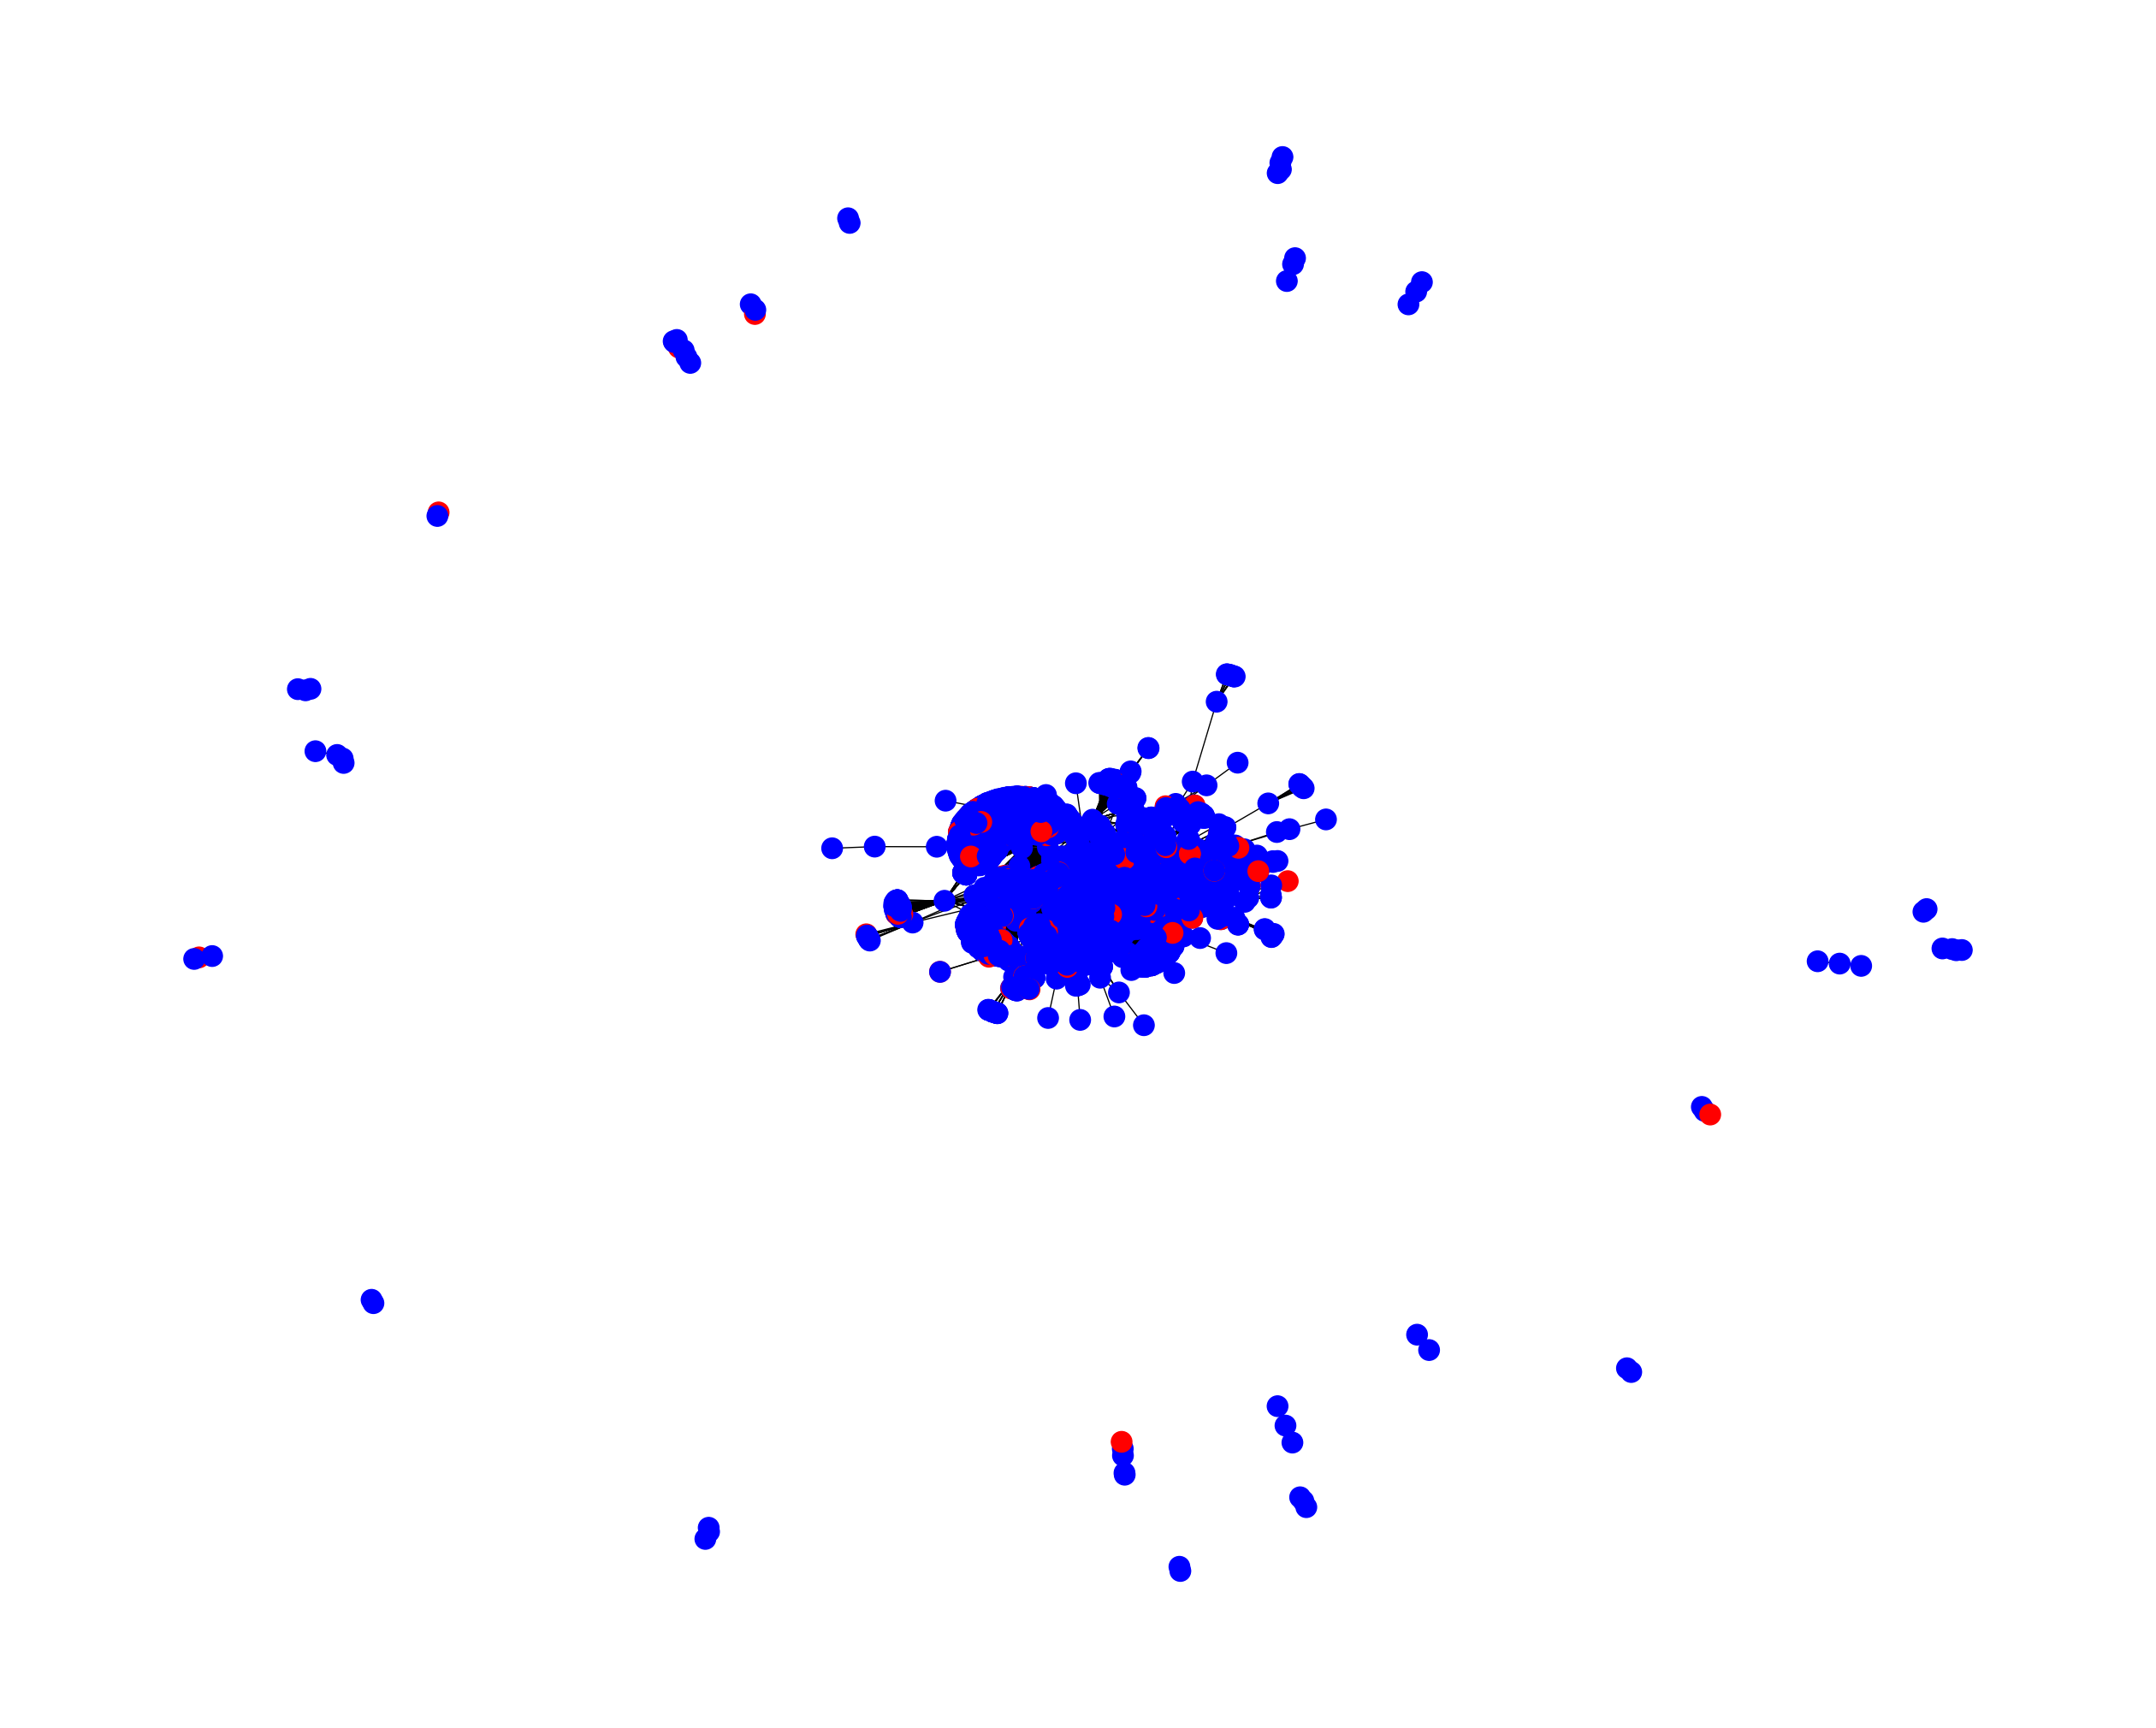

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

le = LabelEncoder()
df['IP_encoded'] = le.fit_transform(df['IP'])
df['Image_encoded'] = le.fit_transform(df['Image'])

node_features = df[['IP_encoded', 'Image_encoded']]

# Train Isolation Forest
clf = IsolationForest(contamination=0.05)
pred = clf.fit_predict(node_features)

# Add anomaly information to the partition dictionary
for i, node in enumerate(G.nodes()):
    part[node] = pred[i] + 1 

anomaly_color = ['red' if pred[i] == -1 else 'blue' for i in range(len(G.nodes()))]

# Visualize the graph with anomaly color
figure(figsize=(25, 20))
nx.draw_spring(G, node_color=anomaly_color, with_labels=False)

In [ ]:
import matplotlib.pyplot as plt

anomaly_threshold = 5

anomalies = [node for node, score in zip(G.nodes(), clf.decision_function(node_features)) if score < anomaly_threshold]

node_labels = {node: node if node in anomalies else '' for node in G.nodes()}

# Visualize the graph with labeled anomalies
figure(figsize=(25, 20))
nx.draw_spring(G, node_color=anomaly_color, labels=node_labels, font_size=8)

outliers_list = [(df.loc[df['IP'] == node, 'Image'].values[0] if len(df.loc[df['IP'] == node, 'Image']) > 0 else None, node) for node in anomalies]

outliers_list = [(image, ip) for image, ip in outliers_list if image is not None]

print("List of Outliers (Image, IP):")
print(outliers_list, "\n")

plt.show()

In [ ]:
outliers_list